In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, recall_score, confusion_matrix, roc_auc_score,
    roc_curve, classification_report
)
from scipy import interpolate


In [ ]:
# === LOAD DATA ==
local_path = "D://package/fistula-recurrence-prediction/training/Fistula Surgery Recurrence_train.xlsx/"
data = pd.read_excel(local_path)
data.head()

,Daerah,Tindakan,Causa,Rute,BMI,Ukuran,Paritas,Jumlah,Usia,Rekuren
0,2,2,1,2,2,1,2,1,37,1
1,2,1,1,1,2,1,2,1,46,0
2,2,1,1,1,3,1,1,1,48,1
3,2,1,1,1,4,1,6,1,44,0
4,2,1,1,1,3,1,0,1,38,0


In [9]:
print(data.columns.tolist())
print(data.info())                   # check types and missing data
print(data.isnull().sum())           # show missing values per column


['Daerah', 'Tindakan', 'Causa', 'Rute', 'BMI', 'Ukuran', 'Paritas', 'Jumlah', 'Usia', 'Rekuren']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Daerah    41 non-null     int64
 1   Tindakan  41 non-null     int64
 2   Causa     41 non-null     int64
 3   Rute      41 non-null     int64
 4   BMI       41 non-null     int64
 5   Ukuran    41 non-null     int64
 6   Paritas   41 non-null     int64
 7   Jumlah    41 non-null     int64
 8   Usia      41 non-null     int64
 9   Rekuren   41 non-null     int64
dtypes: int64(10)
memory usage: 3.3 KB
None
Daerah      0
Tindakan    0
Causa       0
Rute        0
BMI         0
Ukuran      0
Paritas     0
Jumlah      0
Usia        0
Rekuren     0
dtype: int64


Below code are for dataset with 5 variables: Fistula Surgery Recurrence_train.xlsx

In [4]:
# === SET TARGET AND FEATURES ===
target_col = "recurrency"
feature_cols = [col for col in data.columns if col != target_col]
print("Unique values per feature:")
for col in feature_cols:
    print(f"{col}: {data[col].nunique()} unique values")


# === ENCODE CATEGORICAL FEATURES ===
X = data[feature_cols].copy()
y = data[target_col].copy()

Unique values per feature:
cause: 3 unique values
route: 5 unique values
BMI: 4 unique values
fistula_size: 3 unique values
age_category: 4 unique values


In [5]:
# Save original for CatBoost
X_catboost = X.copy()

In [6]:
# Encode categoricals
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
encoders = {}
for col in cat_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le

In [7]:
# Normalize for SVM and kNN
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [8]:
# === TRAIN TEST SPLIT ===
X_train_cat, X_test_cat, y_train, y_test = train_test_split(X_catboost, y, test_size=0.2, random_state=42)
X_train_scaled, X_test_scaled = train_test_split(X_scaled, test_size=0.2, random_state=42)

In [9]:
# === DEFINE MODELS ===

""" models = {
     "CatBoost": CatBoostClassifier(iterations=300, learning_rate=0.1, depth=6, 
                                    cat_features=cat_features, verbose=0, random_seed=42),
     "SVM": SVC(probability=True, kernel='rbf', random_state=42),
     "kNN": KNeighborsClassifier(n_neighbors=5),
     "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
     "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42)
 } """

cb = CatBoostClassifier(iterations=300, learning_rate=0.1, depth=6, cat_features=cat_features, verbose=0, random_seed=42)
svm = SVC(probability=True, kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)

results = {}



TRAIN AND EVALUATE MODELS



=== CatBoost ===
              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.40      1.00      0.57         2

    accuracy                           0.67         9
   macro avg       0.70      0.79      0.65         9
weighted avg       0.87      0.67      0.69         9

Accuracy: 0.67
Sensitivity (Recall): 1.00
Specificity: 0.57
AUC-ROC: 0.71

=== SVM ===
              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.33      0.50      0.40         2

    accuracy                           0.67         9
   macro avg       0.58      0.61      0.58         9
weighted avg       0.72      0.67      0.69         9

Accuracy: 0.67
Sensitivity (Recall): 0.50
Specificity: 0.71
AUC-ROC: 0.43

=== kNN ===
              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.33      0.50      0.40  

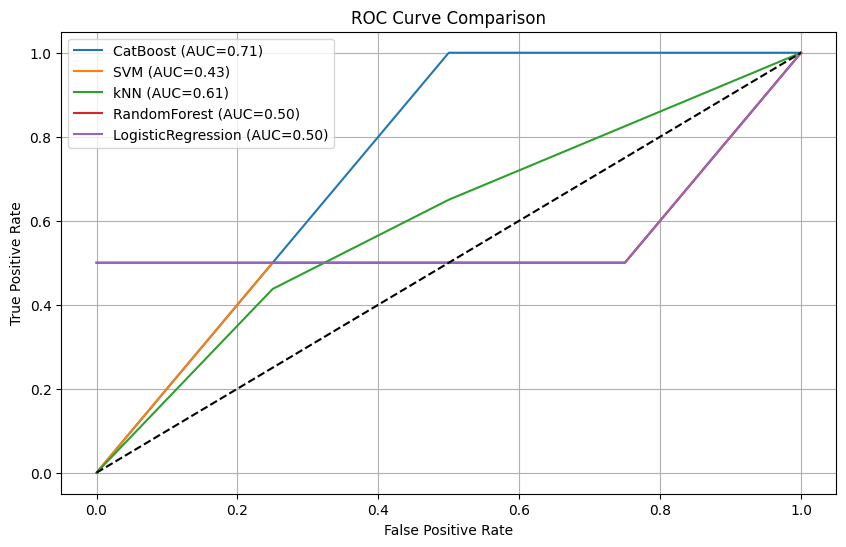

In [51]:
for name, model in models.items():
     print(f"\n=== {name} ===")
    
     if name == "CatBoost":
         model.fit(X_train_cat, y_train)
         y_pred = model.predict(X_test_cat)
         y_proba = model.predict_proba(X_test_cat)[:, 1]
         importance = pd.DataFrame({
             "Feature": model.feature_names_,
             "Importance": model.get_feature_importance()
         }).sort_values(by="Importance", ascending=False)
     else:
         model.fit(X_train_scaled, y_train)
         y_pred = model.predict(X_test_scaled)
         y_proba = model.predict_proba(X_test_scaled)[:, 1]
         try:
             importance = pd.DataFrame({
                 "Feature": X.columns,
                 "Importance": model.feature_importances_
             }).sort_values(by="Importance", ascending=False)
         except:
             importance = None

     acc = accuracy_score(y_test, y_pred)
     recall = recall_score(y_test, y_pred)
     cm = confusion_matrix(y_test, y_pred)
     specificity = cm[0][0] / (cm[0][0] + cm[0][1])
     auc = roc_auc_score(y_test, y_proba)

     print(classification_report(y_test, y_pred))
     print(f"Accuracy: {acc:.2f}")
     print(f"Sensitivity (Recall): {recall:.2f}")
     print(f"Specificity: {specificity:.2f}")
     print(f"AUC-ROC: {auc:.2f}")
    
     # === PLOT ROC CURVE ===
     fpr, tpr, _ = roc_curve(y_test, y_proba)
     fpr_interpolate = np.linspace(0, 1, 5)
     tpr_interpolate = np.interp(fpr_interpolate, fpr, tpr)
     results[name] = {
         "fpr": fpr,
         "fpr_interpolate": fpr_interpolate,
         "tpr": tpr,
         "tpr_interpolate": tpr_interpolate,
         "auc": auc,
         "importance": importance
     }
    
    #  plt.figure(figsize=(10, 6))
    #  plt.plot(fpr_interpolate, tpr_interpolate, label=f"AUC {name} = {auc:.2f}", color="blue")
    #  # plt.step(fpr_interpolate, tpr_interpolate, where='post', label='AUC = ...', linewidth=2)
    #  plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    #  plt.xlabel("False Positive Rate")
    #  plt.ylabel("True Positive Rate")
    #  plt.title("ROC Curve")
    #  plt.legend()
    #  plt.grid()
    #  plt.show()


        
plt.figure(figsize=(10, 6))
for name, res in results.items():
    plt.plot(res["fpr_interpolate"], res["tpr_interpolate"], label=f"{name} (AUC={res['auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()



=== CatBoost ===
              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.40      1.00      0.57         2

    accuracy                           0.67         9
   macro avg       0.70      0.79      0.65         9
weighted avg       0.87      0.67      0.69         9

Accuracy: 0.67
Sensitivity (Recall): 1.00
Specificity: 0.57
AUC-ROC: 0.71


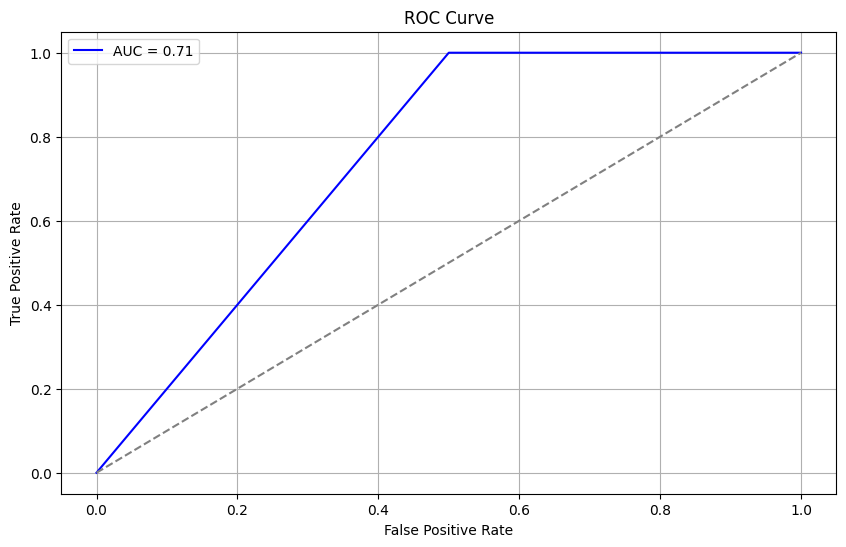

In [10]:
# === CatBoost Model === 
print("\n=== CatBoost ===")
cb.fit(X_train_cat, y_train)
y_pred = cb.predict(X_test_cat)
y_proba = cb.predict_proba(X_test_cat)[:, 1]
cb_importance = pd.DataFrame({
        "Feature": cb.feature_names_,
        "Importance": cb.get_feature_importance()
    }).sort_values(by="Importance", ascending=False)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
specificity = cm[0][0] / (cm[0][0] + cm[0][1])
auc = roc_auc_score(y_test, y_proba)

print(classification_report(y_test, y_pred))
print(f"Accuracy: {acc:.2f}")
print(f"Sensitivity (Recall): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"AUC-ROC: {auc:.2f}")

# Show ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
fpr_interpolate = np.linspace(0, 1, 5)
tpr_interpolate = np.interp(fpr_interpolate, fpr, tpr)
results = {
    "fpr": fpr,
    "tpr": tpr,
    "auc": auc,
    "importance": cb_importance
}   
plt.figure(figsize=(10, 6))
plt.plot(fpr_interpolate, tpr_interpolate, label=f"AUC = {auc:.2f}", color="blue")
# plt.step(fpr_interpolate, tpr_interpolate, where='post', label='AUC = ...', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


=== SVM ===
              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.33      0.50      0.40         2

    accuracy                           0.67         9
   macro avg       0.58      0.61      0.58         9
weighted avg       0.72      0.67      0.69         9

Accuracy: 0.67
Sensitivity (Recall): 0.50
Specificity: 0.71
AUC-ROC: 0.43


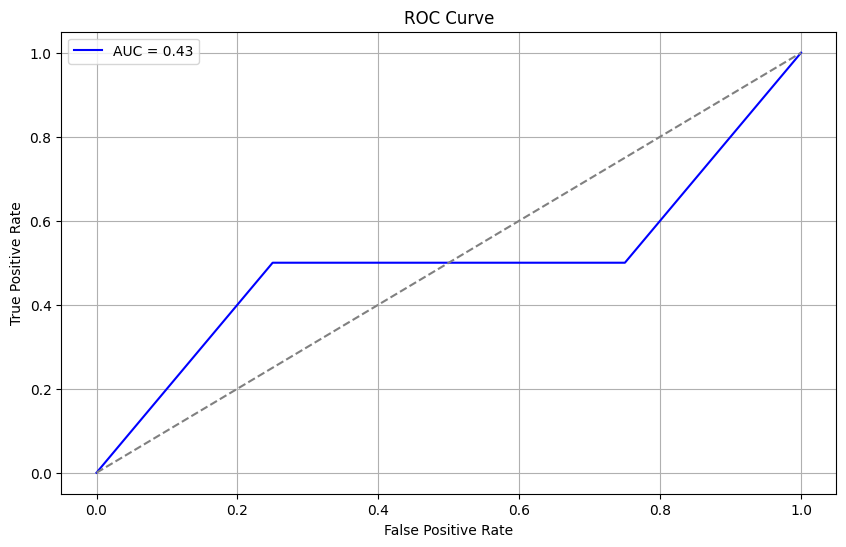

In [35]:
# === SVM Model ===
print("\n=== SVM ===")
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)
y_proba = svm.predict_proba(X_test_scaled)[:, 1]
try:
    svm_importance = pd.DataFrame({
        "Feature": X.columns,
        "Importance": svm.feature_importances_
    }).sort_values(by="Importance", ascending=False)
except:
    svm_importance = None

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
specificity = cm[0][0] / (cm[0][0] + cm[0][1])
auc = roc_auc_score(y_test, y_proba)

print(classification_report(y_test, y_pred))
print(f"Accuracy: {acc:.2f}")
print(f"Sensitivity (Recall): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"AUC-ROC: {auc:.2f}")

# Show ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
fpr_interpolate = np.linspace(0, 1, 5)
tpr_interpolate = np.interp(fpr_interpolate, fpr, tpr)
results = {
    "fpr": fpr,
    "tpr": tpr,
    "auc": auc,
    "importance": svm_importance
}   
plt.figure(figsize=(10, 6))
plt.plot(fpr_interpolate, tpr_interpolate, label=f"AUC = {auc:.2f}", color="blue")
# plt.step(fpr_interpolate, tpr_interpolate, where='post', label='AUC = ...', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


=== KNN ===
              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.33      0.50      0.40         2

    accuracy                           0.67         9
   macro avg       0.58      0.61      0.58         9
weighted avg       0.72      0.67      0.69         9

Accuracy: 0.67
Sensitivity (Recall): 0.50
Specificity: 0.71
AUC-ROC: 0.61


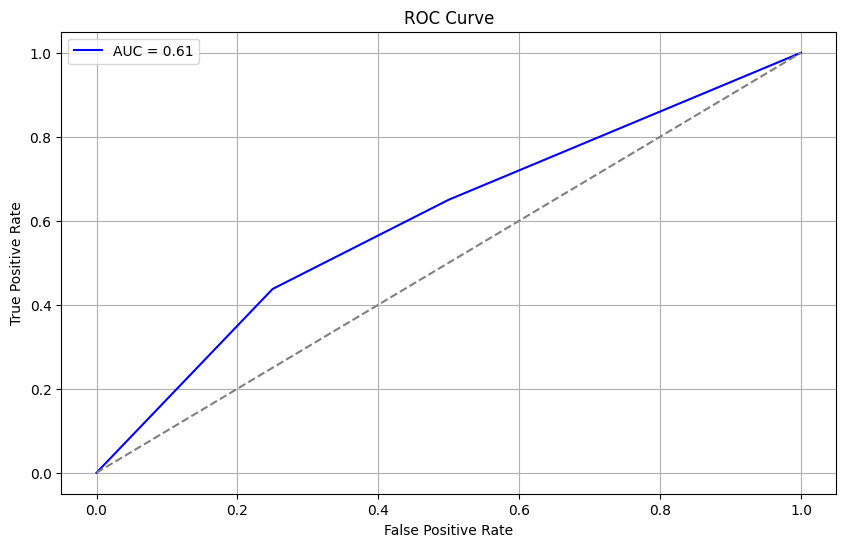

In [36]:
# === KNN Model ===
print("\n=== KNN ===")
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
y_proba = knn.predict_proba(X_test_scaled)[:, 1]
try:
    knn_importance = pd.DataFrame({
        "Feature": X.columns,
        "Importance": knn.feature_importances_
    }).sort_values(by="Importance", ascending=False)
except:
    knn_importance = None

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
specificity = cm[0][0] / (cm[0][0] + cm[0][1])
auc = roc_auc_score(y_test, y_proba)

print(classification_report(y_test, y_pred))
print(f"Accuracy: {acc:.2f}")
print(f"Sensitivity (Recall): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"AUC-ROC: {auc:.2f}")

# Show ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
fpr_interpolate = np.linspace(0, 1, 5)
tpr_interpolate = np.interp(fpr_interpolate, fpr, tpr)
results = {
    "fpr": fpr,
    "tpr": tpr,
    "auc": auc,
    "importance": knn_importance
}   
plt.figure(figsize=(10, 6))
plt.plot(fpr_interpolate, tpr_interpolate, label=f"AUC = {auc:.2f}", color="blue")
# plt.step(fpr_interpolate, tpr_interpolate, where='post', label='AUC = ...', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


=== Random Fores ===
              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.25      0.50      0.33         2

    accuracy                           0.56         9
   macro avg       0.53      0.54      0.50         9
weighted avg       0.68      0.56      0.59         9

Accuracy: 0.56
Sensitivity (Recall): 0.50
Specificity: 0.57
AUC-ROC: 0.50


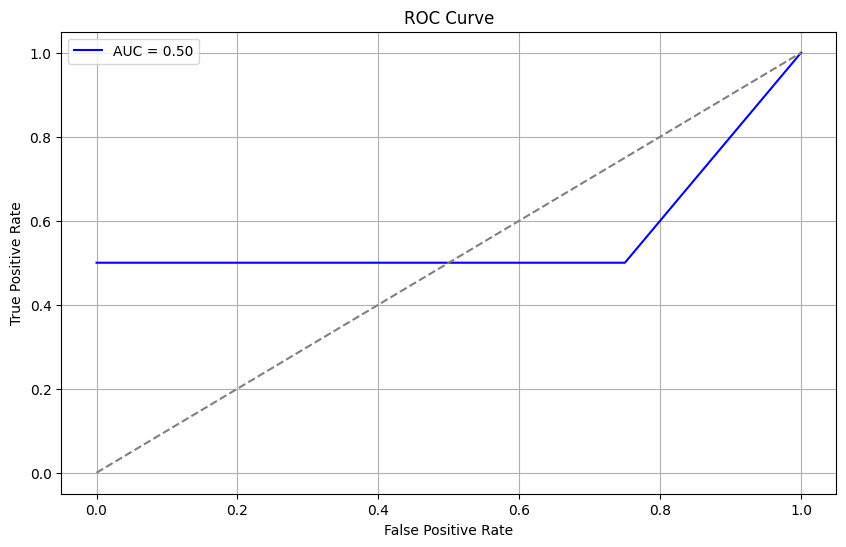

In [37]:
# === Random Forest Model ===
print("\n=== Random Fores ===")
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]
try:
    rf_importance = pd.DataFrame({
        "Feature": X.columns,
        "Importance": rf.feature_importances_
    }).sort_values(by="Importance", ascending=False)
except:
    rf_importance = None

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
specificity = cm[0][0] / (cm[0][0] + cm[0][1])
auc = roc_auc_score(y_test, y_proba)

print(classification_report(y_test, y_pred))
print(f"Accuracy: {acc:.2f}")
print(f"Sensitivity (Recall): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"AUC-ROC: {auc:.2f}")

# Show ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
fpr_interpolate = np.linspace(0, 1, 5)
tpr_interpolate = np.interp(fpr_interpolate, fpr, tpr)
results = {
    "fpr": fpr,
    "tpr": tpr,
    "auc": auc,
    "importance": rf_importance
}   
plt.figure(figsize=(10, 6))
plt.plot(fpr_interpolate, tpr_interpolate, label=f"AUC = {auc:.2f}", color="blue")
# plt.step(fpr_interpolate, tpr_interpolate, where='post', label='AUC = ...', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.25      0.50      0.33         2

    accuracy                           0.56         9
   macro avg       0.53      0.54      0.50         9
weighted avg       0.68      0.56      0.59         9

Accuracy: 0.56
Sensitivity (Recall): 0.50
Specificity: 0.57
AUC-ROC: 0.50


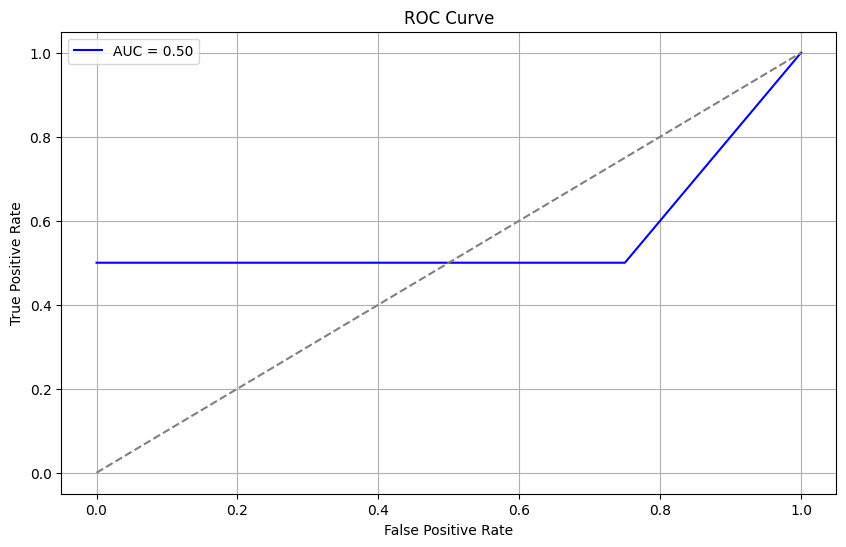

In [38]:
# === Logistic Regression Model ===
print("\n=== Logistic Regression ===")
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]
try:
    lr_importance = pd.DataFrame({
        "Feature": X.columns,
        "Importance": lr.feature_importances_
    }).sort_values(by="Importance", ascending=False)
except:
    lr_importance = None

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
specificity = cm[0][0] / (cm[0][0] + cm[0][1])
auc = roc_auc_score(y_test, y_proba)

print(classification_report(y_test, y_pred))
print(f"Accuracy: {acc:.2f}")
print(f"Sensitivity (Recall): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"AUC-ROC: {auc:.2f}")

# Show ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
fpr_interpolate = np.linspace(0, 1, 5)
tpr_interpolate = np.interp(fpr_interpolate, fpr, tpr)
results = {
    "fpr": fpr,
    "tpr": tpr,
    "auc": auc,
    "importance": lr_importance
}   
plt.figure(figsize=(10, 6))
plt.plot(fpr_interpolate, tpr_interpolate, label=f"AUC = {auc:.2f}", color="blue")
# plt.step(fpr_interpolate, tpr_interpolate, where='post', label='AUC = ...', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

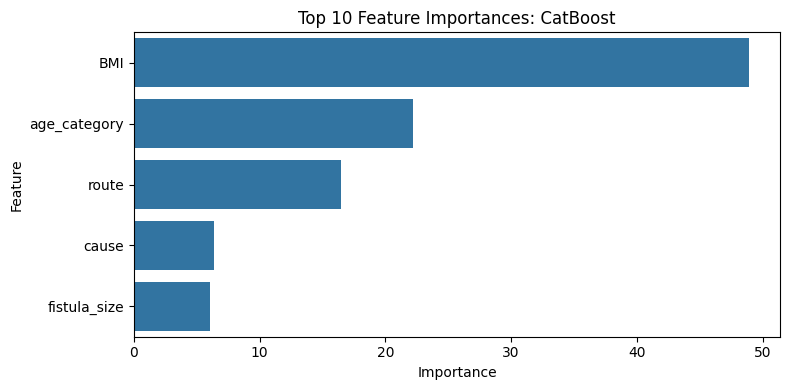

NameError: name 'rf_importance' is not defined

<Figure size 800x400 with 0 Axes>

In [11]:
# === FEATURE IMPORTANCE PLOTS ===


plt.figure(figsize=(8, 4))
sns.barplot(data=cb_importance.head(10), x="Importance", y="Feature")
plt.title("Top 10 Feature Importances: CatBoost")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 4))
sns.barplot(data=rf_importance.head(10), x="Importance", y="Feature")
plt.title("Top 10 Feature Importances: Random Forest")
plt.tight_layout()
plt.show()

# for name, res in results.items():
#     if res["importance"] is not None:
#         plt.figure(figsize=(8, 4))
#         sns.barplot(data=res["importance"].head(10), x="Importance", y="Feature")
#         plt.title(f"Top 10 Feature Importances: {name}")
#         plt.tight_layout()
#         plt.show()

In [12]:
# Save best model
best_model = cb  # example: Random Forest
joblib.dump(best_model, 'catboost001.pkl')
print("Model saved to catboost001.pkl")

Model saved to catboost001.pkl
